## Lab 11 - TextMining

Text Feature Extraction for Classification

*(adapted from Olivier Grisel's tutorial)*

<style>
div.input {
    width: 105ex; /* about 80 chars + buffer */
}
div.text_cell {
    width: 105ex; /* instead of 100%, */
}
div.text_cell_render {
    /*font-family: "Helvetica Neue", Arial, Helvetica, Geneva, sans-serif;*/
    font-family: "Charis SIL", serif !important; /* Make non-code text serif. */
    line-height: 145% !important; /* added for some line spacing of text. */
    width: 105ex !important; /* instead of 'inherit' for shorter lines */
}
/* Set the size of the headers */
div.text_cell_render h1 {
    font-size: 18pt;
}
div.text_cell_render h2 {
    font-size: 14pt;
}
.CodeMirror {
     font-family: Consolas, monospace;
}
</style>

Outline of this section:

- Turn a corpus of text documents into **feature vectors** using a **Bag of Words** representation,
- Train a simple text classifier on the feature vectors,
- Wrap the vectorizer and the classifier with a **pipeline**,
- Cross-validation and **model selection** on the pipeline.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from seaborn import plt

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

### Check that you have the datasets

In [14]:
%run fetch_data.py

Creating datasets folder: /Users/aprilsong/Documents/data_science/DAT_SF_12/datasets
Checking availability of the 20 newsgroups dataset
Decompressing /Users/aprilsong/Documents/data_science/DAT_SF_12/datasets/20news-bydate.tar.gz
Checking that the 20 newsgroups files exist...
=> Success!
Checking availability of the titanic dataset
=> Success!


In [15]:
!ls -lh datasets/

total 28376
drwxr-xr-x  22 aprilsong  staff   748B Mar 18  2003 20news-bydate-test
drwxr-xr-x  22 aprilsong  staff   748B Mar 18  2003 20news-bydate-train
-rw-r--r--   1 aprilsong  staff    14M Feb 26 20:25 20news-bydate.tar.gz
-rw-r--r--   1 aprilsong  staff    60K Feb 26 20:25 titanic_train.csv


## Text Classification in 20 lines of Python

Let's start by implementing a canonical text classification example:

- The 20 newsgroups dataset: around 18000 text posts from 20 newsgroups forums
- Bag of Words features extraction with TF-IDF weighting
- Naive Bayes classifier or Linear Support Vector Machine for the classifier itself

In [6]:
y_train

array([1, 2, 2, ..., 2, 1, 1])

In [2]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Load the text data
categories = [ #actual folders..only want data from these folders
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
twenty_train_small = load_files('datasets/20news-bydate-train/',
    categories=categories, encoding='latin-1')
twenty_test_small = load_files('datasets/20news-bydate-test/',
    categories=categories, encoding='latin-1')

# Turn the text documents into vectors of word frequencies
vectorizer = TfidfVectorizer(min_df=2) 
X_train = vectorizer.fit_transform(twenty_train_small.data)
y_train = twenty_train_small.target

# Fit a classifier on the training set
classifier = MultinomialNB().fit(X_train, y_train)
print("Training score: {0:.1f}%".format(
    classifier.score(X_train, y_train) * 100))

# Evaluate the classifier on the testing set
X_test = vectorizer.transform(twenty_test_small.data)
y_test = twenty_test_small.target
print("Testing score: {0:.1f}%".format(
    classifier.score(X_test, y_test) * 100))

[Multinomial Naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes)
--------------------------------------------------------
`MultinomialNB` implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice). The distribution is parametrized by vectors $\theta_y = (\theta_{y1},\ldots,\theta_{yn})$ for each class $y$, where $n$ is the number of features (in text classification, the size of the vocabulary) and $\theta_{yi}$ is the probability $P(x_i \mid y)$ of feature $i$ appearing in a sample belonging to class $y$.

The parameters $\theta_y$ is estimated by a smoothed version of maximum likelihood, i.e. relative frequency counting:

$$ \hat{\theta}_{yi} = \frac{ N_{yi} + \alpha}{N_y + \alpha n} $$

where $N_{yi} = \sum_{x \in T} x_i$ is the number of times feature $i$ appears in a sample of class $y$ in the training set $T$, and $N_{y} = \sum_{i=1}^{|T|} N_{yi}$ is the total count of all features for class $y$.

The smoothing priors $\alpha \ge 0$ accounts for features not present in the learning samples and prevents zero probabilities in further computations. Setting $\alpha = 1$ is called Laplace smoothing, while $\alpha < 1$ is called Lidstone smoothing.

Let's now decompose what we just did to understand and customize each step.

### Loading the Dataset

Let's explore the dataset loading utility without passing a list of categories: in this case we load the full 20 newsgroups dataset in memory. The source website for the 20 newsgroups already provides a date-based train / test split that is made available using the `subset` keyword argument: 

In [17]:
ls datasets/

20news-bydate-test/   20news-bydate.tar.gz
20news-bydate-train/  titanic_train.csv


In [18]:
ls -lh datasets/20news-bydate-train

total 0
drwxr-xr-x  482 aprilsong  staff    16K Mar 18  2003 alt.atheism/
drwxr-xr-x  586 aprilsong  staff    19K Mar 18  2003 comp.graphics/
drwxr-xr-x  593 aprilsong  staff    20K Mar 18  2003 comp.os.ms-windows.misc/
drwxr-xr-x  592 aprilsong  staff    20K Mar 18  2003 comp.sys.ibm.pc.hardware/
drwxr-xr-x  580 aprilsong  staff    19K Mar 18  2003 comp.sys.mac.hardware/
drwxr-xr-x  595 aprilsong  staff    20K Mar 18  2003 comp.windows.x/
drwxr-xr-x  587 aprilsong  staff    19K Mar 18  2003 misc.forsale/
drwxr-xr-x  596 aprilsong  staff    20K Mar 18  2003 rec.autos/
drwxr-xr-x  600 aprilsong  staff    20K Mar 18  2003 rec.motorcycles/
drwxr-xr-x  599 aprilsong  staff    20K Mar 18  2003 rec.sport.baseball/
drwxr-xr-x  602 aprilsong  staff    20K Mar 18  2003 rec.sport.hockey/
drwxr-xr-x  597 aprilsong  staff    20K Mar 18  2003 sci.crypt/
drwxr-xr-x  593 aprilsong  staff    20K Mar 18  2003 sci.electronics/
drwxr-xr-x  596 aprilsong  staff    20K Mar 18  2003 sci.med/
drwxr-xr-x  595

In [19]:
ls -lh datasets/20news-bydate-train/alt.atheism/ | head -n27

total 4480
-rw-r--r--  1 aprilsong  staff    12K Mar 18  2003 49960
-rw-r--r--  1 aprilsong  staff    31K Mar 18  2003 51060
-rw-r--r--  1 aprilsong  staff   4.0K Mar 18  2003 51119
-rw-r--r--  1 aprilsong  staff   1.6K Mar 18  2003 51120
-rw-r--r--  1 aprilsong  staff   773B Mar 18  2003 51121
-rw-r--r--  1 aprilsong  staff   4.8K Mar 18  2003 51122
-rw-r--r--  1 aprilsong  staff   618B Mar 18  2003 51123
-rw-r--r--  1 aprilsong  staff   1.4K Mar 18  2003 51124
-rw-r--r--  1 aprilsong  staff   2.7K Mar 18  2003 51125
-rw-r--r--  1 aprilsong  staff   427B Mar 18  2003 51126
-rw-r--r--  1 aprilsong  staff   742B Mar 18  2003 51127
-rw-r--r--  1 aprilsong  staff   650B Mar 18  2003 51128
-rw-r--r--  1 aprilsong  staff   1.3K Mar 18  2003 51130
-rw-r--r--  1 aprilsong  staff   2.3K Mar 18  2003 51131
-rw-r--r--  1 aprilsong  staff   2.6K Mar 18  2003 51132
-rw-r--r--  1 aprilsong  staff   1.5K Mar 18  2003 51133
-rw-r--r--  1 aprilsong  staff   1.2K Mar 18  2003 51134
-rw-r--r--  1 aprils

The `load_files` function can load text files from a 2 levels folder structure assuming folder names represent categories:

In [20]:
print(load_files.__doc__)

Load text files with categories as subfolder names.

    Individual samples are assumed to be files stored a two levels folder
    structure such as the following:

        container_folder/
            category_1_folder/
                file_1.txt
                file_2.txt
                ...
                file_42.txt
            category_2_folder/
                file_43.txt
                file_44.txt
                ...

    The folder names are used as supervised signal label names. The
    individual file names are not important.

    This function does not try to extract features into a numpy array or
    scipy sparse matrix. In addition, if load_content is false it
    does not try to load the files in memory.

    To use text files in a scikit-learn classification or clustering
    algorithm, you will need to use the `sklearn.feature_extraction.text`
    module to build a feature extraction transformer that suits your
    problem.

    If you set load_content=True, you shou

In [15]:
all_twenty_train = load_files('datasets/20news-bydate-train/',
  encoding='latin-1', random_state=42)
all_twenty_test = load_files('datasets/20news-bydate-test/',
    encoding='latin-1', random_state=42)

In [16]:
all_target_names = all_twenty_train.target_names
all_target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [17]:
all_twenty_train.target # first target is from 12th row, second target from 6th row, etc

array([12,  6,  9, ...,  9,  1, 12])

In [24]:
all_twenty_train.target.shape

(11314,)

In [25]:
all_twenty_test.target.shape

(7532,)

In [26]:
len(all_twenty_train.data)

11314

In [27]:
type(all_twenty_train.data[0])

unicode

In [3]:
def display_sample(i, dataset):
    print("Class name: " + dataset.target_names[dataset.target[i]])
    print("Text content:\n")
    print(dataset.data[i])

In [29]:
display_sample(0, all_twenty_train)

Class name: sci.electronics
Text content:

From: wtm@uhura.neoucom.edu (Bill Mayhew)
Subject: Re: How to the disks copy protected.
Organization: Northeastern Ohio Universities College of Medicine
Lines: 23

Write a good manual to go with the software.  The hassle of
photocopying the manual is offset by simplicity of purchasing
the package for only $15.  Also, consider offering an inexpensive
but attractive perc for registered users.  For instance, a coffee
mug.  You could produce and mail the incentive for a couple of
dollars, so consider pricing the product at $17.95.

You're lucky if only 20% of the instances of your program in use
are non-licensed users.

The best approach is to estimate your loss and accomodate that into
your price structure.  Sure it hurts legitimate users, but too bad.
Retailers have to charge off loss to shoplifters onto paying
customers; the software industry is the same.

Unless your product is exceptionally unique, using an ostensibly
copy-proof disk will jus

In [30]:
display_sample(1, all_twenty_train)

Class name: misc.forsale
Text content:

From: andy@SAIL.Stanford.EDU (Andy Freeman)
Subject: Re: Catalog of Hard-to-Find PC Enhancements (Repost)
Organization: Computer Science Department,  Stanford University.
Lines: 33

>andy@SAIL.Stanford.EDU (Andy Freeman) writes:
>> >In article <C5ELME.4z4@unix.portal.com> jdoll@shell.portal.com (Joe Doll) wr
>> >>   "The Catalog of Personal Computing Tools for Engineers and Scien-
>> >>   tists" lists hardware cards and application software packages for 
>> >>   PC/XT/AT/PS/2 class machines.  Focus is on engineering and scien-
>> >>   tific applications of PCs, such as data acquisition/control, 
>> >>   design automation, and data analysis and presentation.  
>> >
>> >>   If you would like a free copy, reply with your (U. S. Postal) 
>> >>   mailing address.
>> 
>> Don't bother - it never comes.  It's a cheap trick for building a
>> mailing list to sell if my junk mail flow is any indication.
>> 
>> -andy sent his address months ago
>
>Perhaps we

Let's compute the (uncompressed, in-memory) size of the training and test sets in MB assuming an 8-bit encoding (in this case, all chars can be encoded using the latin-1 charset).

In [19]:
def text_size(text, charset='iso-8859-1'):
    return len(text.encode(charset)) * 8 * 1e-6

train_size_mb = sum(text_size(text) for text in all_twenty_train.data) 
test_size_mb = sum(text_size(text) for text in all_twenty_test.data)

print("Training set size: {0} MB".format(int(train_size_mb)))
print("Testing set size: {0} MB".format(int(test_size_mb)))

Training set size: 176 MB
Testing set size: 110 MB


If we only consider a small subset of the 4 categories selected from the initial example:

In [20]:
train_small_size_mb = sum(text_size(text) for text in twenty_train_small.data) 
test_small_size_mb = sum(text_size(text) for text in twenty_test_small.data)

print("Training set size: {0} MB".format(int(train_small_size_mb)))
print("Testing set size: {0} MB".format(int(test_small_size_mb)))

Training set size: 31 MB
Testing set size: 22 MB


### Extracting Text Features

* Terms that occur in only a few documents are often more valuable than ones that occur in many – inverse document frequency (${IDF}_j$)
* The more often a term occurs in a document, the more likely it is to be important for that document – term frequency (${TF}_{ij}$)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

TfidfVectorizer()

TfidfVectorizer(analyzer=u'word', binary=False, charset=None,
        charset_error=None, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [22]:
vectorizer = TfidfVectorizer(min_df=1)

%time X_train_small = vectorizer.fit_transform(twenty_train_small.data)

CPU times: user 686 ms, sys: 23.7 ms, total: 710 ms
Wall time: 708 ms


The results is not a `numpy.array` but instead a `scipy.sparse` matrix. _(Similar to the DocumentTermMatrix in R's `tm` library.)_ This datastructure is quite similar to a 2D numpy array but it does not store the zeros.

In [35]:
X_train_small

<2034x34118 sparse matrix of type '<type 'numpy.float64'>'
	with 323433 stored elements in Compressed Sparse Row format>

scipy.sparse matrices also have a shape attribute to access the dimensions:

In [23]:
n_samples, n_features = X_train_small.shape

This dataset has around 2000 samples (the rows of the data matrix):

In [37]:
n_samples

2034

This is the same value as the number of strings in the original list of text documents:

In [38]:
len(twenty_train_small.data)

2034

The columns represent the individual token occurrences:

In [39]:
n_features

34118

This number is the size of the vocabulary of the model extracted during fit in a Python dictionary:

In [40]:
type(vectorizer.vocabulary_)

dict

In [41]:
len(vectorizer.vocabulary_)

34118

The keys of the `vocabulary_` attribute are also called feature names and can be accessed as a list of strings.

In [42]:
len(vectorizer.get_feature_names())

34118

Here are the first 10 elements (sorted in lexicographical order):

In [43]:
vectorizer.get_feature_names()[:10]

[u'00',
 u'000',
 u'0000',
 u'00000',
 u'000000',
 u'000005102000',
 u'000021',
 u'000062david42',
 u'0000vec',
 u'0001']

Let's have a look at the features from the middle:

In [44]:
vectorizer.get_feature_names()[n_features / 2:n_features / 2 + 10]

[u'inadequate',
 u'inala',
 u'inalienable',
 u'inane',
 u'inanimate',
 u'inapplicable',
 u'inappropriate',
 u'inappropriately',
 u'inaudible',
 u'inbreeding']

### Training a Classifier on Text Features

We have previously extracted a vector representation of the training corpus and put it into a variable name `X_train_small`. To train a supervised model, in this case a classifier, we also need 

In [24]:
y_train_small = twenty_train_small.target

In [46]:
y_train_small.shape

(2034,)

We can shape that we have the same number of samples for the input data and the labels:

In [25]:
X_train_small.shape[0] == y_train_small.shape[0]

True

We can now train a classifier, for instance a Multinomial Naive Bayesian classifier:

In [5]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=0.1)
clf

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [27]:
clf.fit(X_train_small, y_train_small)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

We can now evaluate the classifier on the testing set. Let's first use the builtin score function, which is the rate of correct classification in the test set:

In [28]:
X_test_small = vectorizer.transform(twenty_test_small.data)
y_test_small = twenty_test_small.target

In [29]:
X_test_small.shape

(1353, 34118)

In [30]:
y_test_small.shape

(1353,)

In [31]:
clf.score(X_test_small, y_test_small)

0.89652623798965259

We can also compute the score on the train set and observe that the model is both overfitting and underfitting a bit at the same time:

In [32]:
clf.score(X_train_small, y_train_small)

0.99262536873156337

### Alternative evaluation metrics

Naïve Bayes is a probabilistic models: instead of just predicting a binary outcome (alt.atheism or talk.religion) given the input features it can also estimates the posterior probability of the outcome given the input features using the `predict_proba` method:

In [33]:
target_predicted_proba = clf.predict_proba(X_test_small)
target_predicted_proba[:5]

array([[  8.57020798e-03,   9.79264055e-01,   7.39862543e-03,
          4.76711125e-03],
       [  4.93074898e-06,   7.23598156e-06,   9.99982629e-01,
          5.20395904e-06],
       [  5.53894730e-02,   4.64943864e-05,   3.61862263e-05,
          9.44527846e-01],
       [  9.95389581e-01,   3.33416235e-05,   3.36336051e-05,
          4.54344426e-03],
       [  2.61756163e-05,   1.95881223e-04,   9.99649240e-01,
          1.28702687e-04]])

By default the decision threshold is 0.5: if we vary the decision threshold from 0 to 1 we could generate a family of binary classifier models that address all the possible trade offs between false positive and false negative prediction errors.

We can summarize the performance of a binary classifier for all the possible thresholds by plotting the ROC curves and quantifying the area under the curve (AUC):

In [6]:
def plot_roc_curve(target_test, target_predicted_proba, categories):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc
    
    for pos_label, category in enumerate(categories):
        fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, pos_label], pos_label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='{} ROC curve (area = {:.3f})'.format(category, roc_auc))
    
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

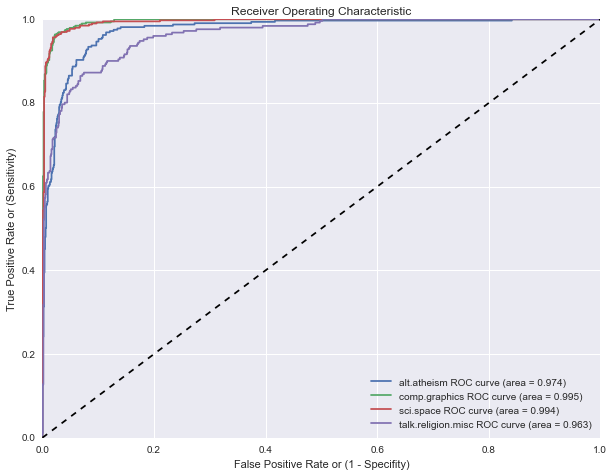

In [35]:
plot_roc_curve(y_test_small, target_predicted_proba, twenty_test_small.target_names)

Here the area under ROC curve ranges between .963 and .974. The ROC-AUC score of a random model is expected to 0.5 on average while the accuracy score of a random model depends on the class imbalance of the data. ROC-AUC can be seen as a way to callibrate the predictive accuracy of a model against class imbalance.

### Introspecting the Behavior of the Text Vectorizer

The text vectorizer has many parameters to customize it's behavior, in particular how it extracts tokens:

In [58]:
TfidfVectorizer()

TfidfVectorizer(analyzer=u'word', binary=False, charset=None,
        charset_error=None, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [59]:
print(TfidfVectorizer.__doc__)

Convert a collection of raw documents to a matrix of TF-IDF features.

    Equivalent to CountVectorizer followed by TfidfTransformer.

    Parameters
    ----------
    input : string {'filename', 'file', 'content'}
        If 'filename', the sequence passed as an argument to fit is
        expected to be a list of filenames that need reading to fetch
        the raw content to analyze.

        If 'file', the sequence items must have a 'read' method (file-like
        object) that is called to fetch the bytes in memory.

        Otherwise the input is expected to be the sequence strings or
        bytes items are expected to be analyzed directly.

    encoding : string, 'utf-8' by default.
        If bytes or files are given to analyze, this encoding is used to
        decode.

    decode_error : {'strict', 'ignore', 'replace'}
        Instruction on what to do if a byte sequence is given to analyze that
        contains characters not of the given `encoding`. By default, it is
     

The easiest way to introspect what the vectorizer is actually doing for a given test of parameters is call the `vectorizer.build_analyzer()` to get an instance of the text analyzer it uses to process the text:

In [36]:
analyzer = TfidfVectorizer().build_analyzer()
analyzer("I love scikit-learn: this is a cool Python lib!")

[u'love', u'scikit', u'learn', u'this', u'is', u'cool', u'python', u'lib']

You can notice that all the tokens are lowercase, that the single letter word "I" was dropped, and that hyphenation is used. Let's change some of that default behavior:

In [37]:
analyzer = TfidfVectorizer(
    preprocessor=lambda text: text,  # disable lowercasing
    token_pattern=ur'(?u)\b[\w-]+\b', # treat hyphen as a letter
                                      # do not exclude single letter tokens
).build_analyzer()

analyzer("I love scikit-learn: this is a cool Python lib!")

[u'I',
 u'love',
 u'scikit-learn',
 u'this',
 u'is',
 u'a',
 u'cool',
 u'Python',
 u'lib']

The analyzer name comes from the Lucene parlance: it wraps the sequential application of:

- text preprocessing (processing the text documents as a whole, e.g. lowercasing)
- text tokenization (splitting the document into a sequence of tokens)
- token filtering and recombination (e.g. n-grams extraction, see later)

The analyzer system of scikit-learn is much more basic than lucene's though.

**Exercise**:

- Write a pre-processor callable (e.g. a python function) to remove the headers of the text a newsgroup post.
- Vectorize the data again and measure the impact on performance of removing the header info from the dataset.
- Do you expect the performance of the model to improve or decrease? What is the score of a uniform random classifier on the same dataset?

Hint: the `TfidfVectorizer` class can accept python functions to customize the `preprocessor`, `tokenizer` or `analyzer` stages of the vectorizer.
    
- type `TfidfVectorizer()` alone in a cell to see the default value of the parameters

- type `TfidfVectorizer.__doc__` to print the constructor parameters doc or `?` suffix operator on a any Python class or method to read the docstring or even the `jQuery203031440189930439577_1424627223304` operator to read the source code.

**Solution**:

Let's write a Python function to strip the post headers and only retain the body (text after the first blank line):

In [7]:
def strip_headers(post):
    """Find the first blank line and drop the headers to keep the body"""
    if '\n\n' in post:
        headers, body = post.split('\n\n', 1)
        return body.lower()
    else:
        # Unexpected post inner-structure, be conservative
        # and keep everything
        return post.lower()

Let's try it on the first post. Here is the original post content, including the headers:

In [63]:
original_text = all_twenty_train.data[0]
print(original_text)

From: wtm@uhura.neoucom.edu (Bill Mayhew)
Subject: Re: How to the disks copy protected.
Organization: Northeastern Ohio Universities College of Medicine
Lines: 23

Write a good manual to go with the software.  The hassle of
photocopying the manual is offset by simplicity of purchasing
the package for only $15.  Also, consider offering an inexpensive
but attractive perc for registered users.  For instance, a coffee
mug.  You could produce and mail the incentive for a couple of
dollars, so consider pricing the product at $17.95.

You're lucky if only 20% of the instances of your program in use
are non-licensed users.

The best approach is to estimate your loss and accomodate that into
your price structure.  Sure it hurts legitimate users, but too bad.
Retailers have to charge off loss to shoplifters onto paying
customers; the software industry is the same.

Unless your product is exceptionally unique, using an ostensibly
copy-proof disk will just send your customers to the competetion.



Here is the result of applying our header stripping function:

In [64]:
text_body = strip_headers(original_text)
print(text_body)

write a good manual to go with the software.  the hassle of
photocopying the manual is offset by simplicity of purchasing
the package for only $15.  also, consider offering an inexpensive
but attractive perc for registered users.  for instance, a coffee
mug.  you could produce and mail the incentive for a couple of
dollars, so consider pricing the product at $17.95.

you're lucky if only 20% of the instances of your program in use
are non-licensed users.

the best approach is to estimate your loss and accomodate that into
your price structure.  sure it hurts legitimate users, but too bad.
retailers have to charge off loss to shoplifters onto paying
customers; the software industry is the same.

unless your product is exceptionally unique, using an ostensibly
copy-proof disk will just send your customers to the competetion.


-- 
bill mayhew      neoucom computer services department
rootstown, oh  44272-9995  usa    phone: 216-325-2511
wtm@uhura.neoucom.edu (140.220.1.1)    146.580: n8w

Let's plug our function in the vectorizer and retrain a naive Bayes classifier (as done initially):

In [40]:
strip_vectorizer = TfidfVectorizer(preprocessor=strip_headers, min_df=2)
X_train_small_stripped = strip_vectorizer.fit_transform(
    twenty_train_small.data)

y_train_small_stripped = twenty_train_small.target

classifier = MultinomialNB().fit(
  X_train_small_stripped, y_train_small_stripped)

print("Training score: {0:.1f}%".format(
    classifier.score(X_train_small_stripped, y_train_small_stripped) * 100))

X_test_small_stripped = strip_vectorizer.transform(twenty_test_small.data)
y_test_small_stripped = twenty_test_small.target
print("Testing score: {0:.1f}%".format(
    classifier.score(X_test_small_stripped, y_test_small_stripped) * 100))

Training score: 93.3%
Testing score: 82.2%


So indeed the header data is making the problem easier (cheating one could say) but naive Bayes classifier can still guess 80% of the time against 1 / 4 == 25% mean score for a random guessing on the small subset with 4 target categories.

## Model Selection of the Naive Bayes Classifier Parameter Alone

The `MultinomialNB` class is a good baseline classifier for text as it's fast and has few parameters to tweak:

In [8]:
MultinomialNB()

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [67]:
print(MultinomialNB.__doc__)


    Naive Bayes classifier for multinomial models

    The multinomial Naive Bayes classifier is suitable for classification with
    discrete features (e.g., word counts for text classification). The
    multinomial distribution normally requires integer feature counts. However,
    in practice, fractional counts such as tf-idf may also work.

    Parameters
    ----------
    alpha : float, optional (default=1.0)
        Additive (Laplace/Lidstone) smoothing parameter
        (0 for no smoothing).

    fit_prior : boolean
        Whether to learn class prior probabilities or not.
        If false, a uniform prior will be used.

    class_prior : array-like, size (n_classes,)
        Prior probabilities of the classes. If specified the priors are not
        adjusted according to the data.

    Attributes
    ----------
    `class_log_prior_` : array, shape (n_classes, )
        Smoothed empirical log probability for each class.

    `intercept_` : property
        Mirrors ``class_lo

By reading the doc we can see that the `alpha` parameter is a good candidate to adjust the model for the bias (underfitting) vs variance (overfitting) trade-off.

## Setting Up a Pipeline for Cross Validation and Model Selection of the Feature Extraction parameters

The feature extraction class has many options to customize its behavior:

In [68]:
print(TfidfVectorizer.__doc__)

Convert a collection of raw documents to a matrix of TF-IDF features.

    Equivalent to CountVectorizer followed by TfidfTransformer.

    Parameters
    ----------
    input : string {'filename', 'file', 'content'}
        If 'filename', the sequence passed as an argument to fit is
        expected to be a list of filenames that need reading to fetch
        the raw content to analyze.

        If 'file', the sequence items must have a 'read' method (file-like
        object) that is called to fetch the bytes in memory.

        Otherwise the input is expected to be the sequence strings or
        bytes items are expected to be analyzed directly.

    encoding : string, 'utf-8' by default.
        If bytes or files are given to analyze, this encoding is used to
        decode.

    decode_error : {'strict', 'ignore', 'replace'}
        Instruction on what to do if a byte sequence is given to analyze that
        contains characters not of the given `encoding`. By default, it is
     

In order to evaluate the impact of the parameters of the feature extraction one can chain a configured feature extraction and classifier:

In [7]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline((
    ('vec', TfidfVectorizer()),
    ('clf', MultinomialNB()),
))

Such a pipeline can then be cross validated or even grid searched:

In [8]:
from sklearn.cross_validation import cross_val_score
from scipy.stats import sem

scores = cross_val_score(pipeline, twenty_train_small.data,
                         twenty_train_small.target, cv=3, n_jobs=3)
scores.mean(), sem(scores) #standard error of the mean (or standard error of measurements) of scores

For the grid search, the parameters names are prefixed with the name of the pipeline step using "__" as a separator:

In [9]:
from sklearn.grid_search import GridSearchCV

parameters = {
    'vec__max_df': [0.8, 1.0], 
    'vec__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': np.logspace(-5, 0, 6)
}

gs = GridSearchCV(pipeline, parameters, verbose=2, refit=False, n_jobs=2)
_ = gs.fit(twenty_train_small.data, twenty_train_small.target)

In [ ]:
gs.best_score_

In [ ]:
gs.best_params_

## Introspecting Model Performance

### Displaying the Most Discriminative Features

Let's fit a model on the small dataset and collect info on the fitted components:

In [45]:
pipeline = Pipeline((
    ('vec', TfidfVectorizer(max_df = 0.8, ngram_range = (1, 2), use_idf=True)), # adds 2 underscores for any parameters i want to add to it
    ('clf', MultinomialNB(alpha = 0.001)),
))
_ = pipeline.fit(twenty_train_small.data, twenty_train_small.target)

In [49]:
vec_name, vec = pipeline.steps[0]
clf_name, clf = pipeline.steps[1]

feature_names = vec.get_feature_names()

target_names = twenty_train_small.target_names


feature_weights = clf.coef_
print feature_weights
feature_weights.shape

[[-11.6448504  -15.98050128 -15.98050128 ..., -15.98050128 -15.98050128
  -15.98050128]
 [ -9.08904489 -12.42717005 -15.90612927 ..., -15.90612927 -15.90612927
  -15.90612927]
 [ -9.32799473 -12.2566081  -13.26267165 ..., -16.12940297 -16.12940297
  -16.12940297]
 [-10.87979783 -15.76124267 -15.76124267 ..., -11.42851903 -11.42851903
  -11.42851903]]


(4, 279569)

By sorting the feature weights on the linear model and asking the vectorizer what their names is, one can get a clue on what the model did actually learn on the data:

In [50]:
def display_important_features(feature_names, target_names, weights, n_top=30):
    for i, target_name in enumerate(target_names):
        print(u"Class: " + target_name)
        print(u"")
        
        sorted_features_indices = weights[i].argsort()[::-1]
        
        most_important = sorted_features_indices[:n_top]
        print(u", ".join(u"{0}: {1:.4f}".format(feature_names[j], weights[i, j])
                        for j in most_important))
        print(u"...")
        
        least_important = sorted_features_indices[-n_top:]
        print(u", ".join(u"{0}: {1:.4f}".format(feature_names[j], weights[i, j])
                        for j in least_important))
        print(u"")
        
display_important_features(feature_names, target_names, feature_weights)

Class: alt.atheism

is: -6.0027, that: -6.0312, you: -6.2511, it: -6.3314, edu: -6.4635, not: -6.5979, keith: -6.6737, are: -6.7286, god: -6.7621, be: -6.7679, this: -6.8508, have: -6.8571, as: -6.9286, for: -6.9742, com: -6.9941, was: -7.0117, if: -7.0161, what: -7.0188, caltech edu: -7.0239, caltech: -7.0395, but: -7.0456, we: -7.0484, they: -7.0532, or: -7.0633, your: -7.0776, an: -7.0856, he: -7.0863, people: -7.1103, one: -7.1105, do: -7.1638
...
occultic writings: -15.9805, occurred close: -15.9805, occurred long: -15.9805, ocean of: -15.9805, occurs program: -15.9805, ocean marvin: -15.9805, ocean mariner: -15.9805, ocean in: -15.9805, ocean dynamics: -15.9805, ocean dt: -15.9805, ocean and: -15.9805, ocean aleph: -15.9805, ocean after: -15.9805, ocean: -15.9805, occurs under: -15.9805, occurs this: -15.9805, occurs now: -15.9805, occurred think: -15.9805, occurs may: -15.9805, occurs in: -15.9805, occurs even: -15.9805, occurs during: -15.9805, occurs at: -15.9805, occurs as: -

### Displaying the per-class Classification Reports

In [10]:
from sklearn.metrics import classification_report

predicted = pipeline.predict(twenty_test_small.data)

In [52]:
print(classification_report(twenty_test_small.target, predicted,
                            target_names=twenty_test_small.target_names))


                    precision    recall  f1-score   support

       alt.atheism       0.83      0.88      0.86       319
     comp.graphics       0.94      0.95      0.94       389
         sci.space       0.94      0.95      0.94       394
talk.religion.misc       0.86      0.76      0.81       251

       avg / total       0.90      0.90      0.90      1353



+ The **precision** is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

+ The **recall** is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

+ The **f1-score** is a measure of a test's accuracy.

### Printing the Confusion Matrix

The confusion matrix summarize which class where by having a look at off-diagonal entries: here we can see that articles about atheism have been wrongly classified as being about religion 57 times for instance: 

In [11]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(twenty_test_small.target, predicted), 
             index = pd.MultiIndex.from_product([['actual'], twenty_test_small.target_names]),
             columns = pd.MultiIndex.from_product([['predicted'], twenty_test_small.target_names]))

In Pairs
=========

```bash
$ unzip Classification_data -d Classification_data
```

1. Load the dateset using `load_files` (hint: our `categories` are now `spam`, `easy_ham`, etc.)
2. Write a pre-processor callable to remove the message headers.
3. Set up a pipeline for cross validation and model selection using `spam` and `easy_ham`.
    - Which parameters should be optimized?
    - Do you expect the results to be different from the parameters above? Why/why not?
    - Are there other parameters we should optimize that we haven't tested?
4. Use `GridSearchCV` to find optimal parameters for vectorizor and classifier.
5. Run classifier against `hard_ham`. What percentage of `hard_ham` does it correctly identify as not `spam`?
6. Display the most discriminative features. Anything stick out?
7. Run classifier against `spam_2`, `easy_ham_2`, `hard_ham_2`. 
    - Plot the ROC curve (along with AUC) for each case. 
    - Print the confusion matrix

On Your Own
========

1. Read the Naïve Bayes documentation at [scikit-learn.org](http://scikit-learn.org/stable/modules/naive_bayes.html). There are three Naïve Bayes classifiers described. Which of the other two might also be appropriate for this task?
2. Explain your choice and apply it to either the spam/ham dataset (if you completed the pair assignment) or the newsgroups dataset (if you didn't).
3. Use grid search cross validation to find the best parameters for both the vectorizor and classifier.
    - Do different parameters for the vectorizor work better for this classifier?
4. Does this classifier do better or worse than the multinomial classifier?
5. Advanced: consider the descriptions of the two classifiers in light of which does better for this problem. Can you posit a theory as to why one classifier should do better than the other?




Load the dateset using `load_files` (hint: our `categories` are now `spam`, `easy_ham`, etc.)

In [20]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB



In [22]:
cd ..

/Users/aprilsong/Documents/data_science


In [23]:
cd DAT_SF_12

/Users/aprilsong/Documents/data_science/DAT_SF_12


In [24]:
categories = ['easy_ham', 'hard_ham', 'spam']
train_data = load_files('Classification_data/train', categories=categories, encoding='latin-1')
test_data = load_files('Classification_data/test', categories=categories, encoding='latin-1')

In [25]:
target_names = train_data.target_names

In [26]:
def strip_headers(post):
    """Find the first blank line and drop the headers to keep the body"""
    if '\n\n' in post:
        headers, body = post.split('\n\n', 1)
        return body.lower()
    else:
        # Unexpected post inner-structure, be conservative
        # and keep everything
        return post.lower()
    


#### Set up a pipeline for cross validation and model selection using `spam` and `easy_ham`.
- Which parameters should be optimized?
- Do you expect the results to be different from the parameters above? Why/why not?
- Are there other parameters we should optimize that we haven't tested?


In [27]:
#    - Which parameters should be optimized?
#    - Do you expect the results to be different from the parameters above? Why/why not?
#    - Are there other parameters we should optimize that we haven't tested?

strip_vectorizer = TfidfVectorizer(preprocessor=strip_headers, min_df=2)

pipeline = Pipeline((
    ('vec', strip_vectorizer),
    ('clf', MultinomialNB()),
))

#### Use GridSearchCV to find optimal parameters for vectorizor and classifier.

In [29]:
from sklearn.grid_search import GridSearchCV

parameters = {
    'vec__max_df': [0.8, 1.0],
    'vec__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': np.logspace(-5, 0, 6)
}

gs = GridSearchCV(pipeline, parameters, verbose=0, refit=False, n_jobs=3)
_ = gs.fit(train_data.data, train_data.target)

In [30]:
gs.best_score_

0.9729480479557332

In [31]:
gs.best_params_

{'clf__alpha': 0.001, 'vec__max_df': 0.8, 'vec__ngram_range': (1, 2)}

In [32]:
pipeline = Pipeline((
    ('vec', TfidfVectorizer(max_df = 0.8, ngram_range = (1, 2), use_idf=True, preprocessor=strip_headers)),
    ('clf', MultinomialNB(alpha = 0.00001)),
))


modelNB = pipeline.fit(train_data.data, train_data.target)

In [33]:
#run the model against the training data
modelNB.score(test_data.data, test_data.target)

0.91532655070561209

#### Run classifier against hard_ham. What percentage of hard_ham does it correctly identify as not spam?

In [34]:
from sklearn.metrics import classification_report
categories2 = ['hard_ham']
hard_ham_train = load_files('Classification_data/train', categories2, encoding='latin-1')
hard_ham_test = load_files('Classification_data/test', categories2, encoding='latin-1')


In [35]:
train_data.target_names

['easy_ham', 'hard_ham', 'spam']

In [36]:
#Show the values in a dataframe
predicted = modelNB.predict(hard_ham_test.data)
actual = hard_ham_test.target
df = pd.DataFrame(actual, columns = ['actual'])
df['predicted'] = predicted
df.head()

,actual,predicted
0,0,0
1,1,1
2,2,2
3,2,2
4,2,0


#### Run classifier against spam_2, easy_ham_2, hard_ham_2.

In [37]:
#reloading the data with all three categories

categories = [
    'spam',
    'hard_ham',
    'easy_ham', 
]

train_data2 = load_files('Classification_data/train',categories=categories, encoding='latin-1')
test_data2 = load_files('Classification_data/train',categories=categories, encoding='latin-1')

pipeline = Pipeline((
    ('vec', TfidfVectorizer(max_df = 0.8, ngram_range = (1, 2), use_idf=True, preprocessor=strip_headers)),
    ('clf', MultinomialNB(alpha = 0.00001)),
))

modelNB = pipeline.fit(train_data2.data, train_data2.target)

In [38]:
modelNB.score(test_data2.data, test_data2.target)

0.99969259145404243

In [39]:
from sklearn.metrics import confusion_matrix

predicted = pipeline.predict(test_data2.data)

pd.DataFrame(confusion_matrix(test_data2.target, predicted), 
             index = pd.MultiIndex.from_product([['actual'], test_data2.target_names]),
             columns = pd.MultiIndex.from_product([['predicted'], test_data2.target_names]))

predicted              
                 easy_ham hard_ham spam
actual easy_ham      2500        1    0
       hard_ham         0      250    0
       spam             0        0  502

In [40]:
def plot_roc_curve(target_test, target_predicted_proba, categories):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc
    
    for pos_label, category in enumerate(categories):
        fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, pos_label], pos_label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='{} ROC curve (area = {:.3f})'.format(category, roc_auc))
    
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

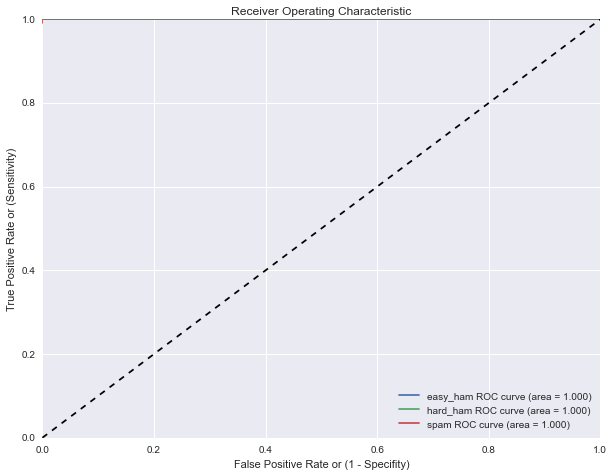

In [41]:
target_predicted_proba = modelNB.predict_proba(test_data2.data)
plot_roc_curve(test_data2.target, target_predicted_proba, test_data2.target_names)

Display the most discriminative features. Anything stick out?